# Sample 배경색 구분, 다중 객체 Crop, 전부 흑백으로 train 처리?

In [8]:
import sys
from pathlib import Path

# 현재 노트북의 디렉토리를 sys.path에 추가
notebook_path = Path().resolve()
sys.path.append(str(notebook_path.parent.parent))

# 이제 config를 import 할 수 있습니다
from src.config import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2

In [9]:
project_root = Path(os.getcwd()).parent.parent

In [10]:
config = get_config()
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정
traindata_dir = os.path.join(project_root,config['data']['train_dir'])
traindata_info_file = config['data']['train_info_file']

# 테스트 데이터의 경로와 정보를 가진 파일의 경로를 설정
testdata_dir = os.path.join(project_root,config['data']['test_dir'])
testdata_info_file = config['data']['test_info_file']

In [11]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기
train_data = pd.read_csv(os.path.join(project_root,traindata_info_file))

# 테스트 데이터
test_data = pd.read_csv(os.path.join(project_root,testdata_info_file))

In [12]:
# glob을 이용하여 이미지 파일의 경로를 읽어옴
train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 15021
Number of test images: 10014


In [13]:
image_prop = defaultdict(list)

for i, path in enumerate(train_images):
    with Image.open(path) as img:
        image_prop['height'].append(img.height)
        image_prop['width'].append(img.width)
        image_prop['img_aspect_ratio'].append(img.width / img.height)
        image_prop['mode'].append(img.mode)
        image_prop['format'].append(img.format)
        image_prop['size'].append(round(os.path.getsize(path) / 1e6, 2))
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('\\')[-2] + "/" + path.split('\\')[-1])
    #print(path.split('\\')[-2] + "/" + path.split('\\')[-1])

image_data = pd.DataFrame(image_prop)

image_data = image_data.merge(train_data, on='image_path')
#image_data.sort_values(by='target', inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_1744\2798227814.py:57: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_1744\2798227814.py:57: UserWarning: Glyph 44191 (\N{HANGUL SYLLABLE GES}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_1744\2798227814.py:57: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_1744\2798227814.py:57: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_1744\2798227814.py:57: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_1744\2798227814.py:57: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
C:\Users\us

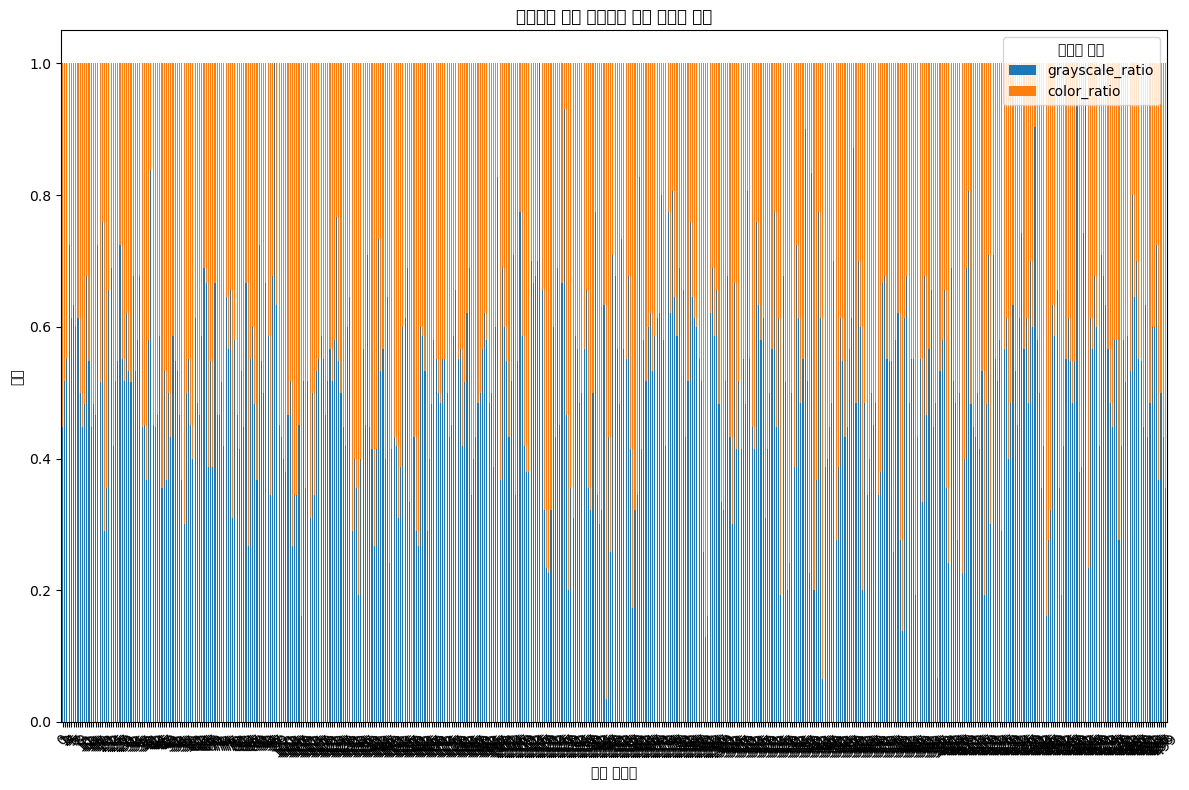

In [16]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def is_grayscale(image_path):
    """
    주어진 경로의 이미지를 RGB 모드로 불러오고,
    모든 픽셀의 R, G, B 값이 동일한지 검사하여 흑백 이미지인지 확인합니다.
    """
    try:
        with Image.open(image_path).convert('RGB') as img:
            # 이미지를 numpy 배열로 변환
            img_array = np.array(img)
            r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]
            
            # 모든 픽셀의 R, G, B 값이 동일한지 검사
            return np.all(r == g) and np.all(g == b)
    except Exception as e:
        print(f"이미지 처리 중 오류 발생 {image_path}: {e}")
        return None

def calculate_image_ratios(image_data):
    """
    각 클래스별 흑백 이미지와 컬러 이미지의 비율을 계산합니다.
    """
    ratios = defaultdict(lambda: {'grayscale': 0, 'color': 0})
    
    for _, row in image_data.iterrows():
        image_path = row['path']
        target_class = row['target']
        image_type = 'grayscale' if is_grayscale(image_path) else 'color'
        if image_type:
            ratios[target_class][image_type] += 1

    # 비율 데이터프레임 생성
    ratio_df = pd.DataFrame.from_dict(ratios, orient='index').fillna(0)
    
    # 총 개수와 비율 계산
    ratio_df['total'] = ratio_df['grayscale'] + ratio_df['color']
    ratio_df['grayscale_ratio'] = ratio_df['grayscale'] / ratio_df['total']
    ratio_df['color_ratio'] = ratio_df['color'] / ratio_df['total']
    
    return ratio_df[['grayscale_ratio', 'color_ratio']]

def plot_ratios(ratio_df):
    """
    흑백 이미지와 컬러 이미지의 비율을 시각화합니다.
    """
    ax = ratio_df[['grayscale_ratio', 'color_ratio']].plot(kind='bar', stacked=True, figsize=(12, 8))
    ax.set_title('클래스별 흑백 이미지와 컬러 이미지 비율')
    ax.set_xlabel('타겟 클래스')
    ax.set_ylabel('비율')
    plt.xticks(rotation=45)
    plt.legend(title='이미지 유형')
    plt.tight_layout()
    plt.show()

# 데이터로부터 비율 계산 및 시각화
# image_data는 'path'와 'target' 열이 포함된 pandas DataFrame
# 예시: image_data = pd.DataFrame({'path': ['path/to/image1.jpg', 'path/to/image2.jpg'], 'target': ['class1', 'class2']})

ratio_df = calculate_image_ratios(image_data)
plot_ratios(ratio_df)